In [1]:
import os
from google.colab import files

# Download dataset
os.chdir('/content')
files.upload()  # Upload the kaggle.json file

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hassan06/nslkdd -p /content/dataset/ --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/hassan06/nslkdd
License(s): unknown
 72% 10.0M/13.9M [00:00<00:00, 19.0MB/s]
100% 13.9M/13.9M [00:00<00:00, 15.0MB/s]


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

# ======================
# Data Loading and Preprocessing
# ======================

# Define column names for the dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load training data
train_df = pd.read_csv('dataset/nsl-kdd/KDDTrain+.txt', names=columns, index_col=False)

# Load test data
test_df = pd.read_csv('dataset/nsl-kdd/KDDTest+.txt', names=columns, index_col=False)

# Combine train and test data for consistent preprocessing
data_df = pd.concat([train_df, test_df], ignore_index=True)

# Drop difficulty level column
data_df = data_df.drop('difficulty_level', axis = 1)

# Drop any columns with only one unique value (if any)
for col in data_df.columns:
    if data_df[col].nunique() == 1:
        data_df.drop(col, axis=1, inplace=True)
        print(f'dropped {col} column since it only has one unique value')

data_df_raw = data_df.copy()

categorical_columns = ['protocol_type', 'service', 'flag', 'label']

# Check the remaining columns (excluding categorical) for their data types
for col in data_df.columns:
    if col not in categorical_columns:
        if not pd.api.types.is_numeric_dtype(data_df[col]):
            print(f"Column '{col}' is not numerical!")

# Check if there are any non-numeric values (like strings or NaNs) in the numerical columns
for col in data_df.columns:
    if col not in categorical_columns:
        non_numeric_values = data_df[col].apply(lambda x: isinstance(x, (int, float)))
        if not all(non_numeric_values):
            print(f"Column '{col}' contains non-numeric values!")

numerical_columns = [col for col in data_df.columns if col not in categorical_columns]

# Identify unique attack types in train and test sets
train_labels = train_df['label'].unique()
test_labels = test_df['label'].unique()

# Find attack types in test set that are not in the train set
unseen_attack_types = set(test_labels) - set(train_labels)
print(f"Number of Unseen attack types in test set: {len(unseen_attack_types)}")

# Replace unseen attack types in the test set with 'other'
data_df['label'] = data_df['label'].apply(lambda x: 'other' if x in unseen_attack_types else x)

# Calculate the final total number of labels for the task
num_classes = len(np.unique(data_df['label']))
print(f"Final Number of classes to classify: {num_classes}")

# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_df[col] = le.fit_transform(data_df[col])
    label_encoders[col] = le  # Save label encoders if needed later for inverse transform

# Normalize numerical columns using StandardScaler
scaler = StandardScaler()
data_df[numerical_columns] = scaler.fit_transform(data_df[numerical_columns])

# Split the data back into train and test sets
train_size = len(train_df)
train_data = data_df[:train_size]
test_data = data_df[train_size:]

# Separate features and labels
x_train_categ = train_data[categorical_columns[:-1]].values  # Exclude the 'label' column
x_train_numer = train_data[numerical_columns].values
y_train = train_data['label'].values

x_test_categ = test_data[categorical_columns[:-1]].values  # Exclude the 'label' column
x_test_numer = test_data[numerical_columns].values
y_test = test_data['label'].values

# Print the shapes to verify
print(f"x_train_categ shape: {x_train_categ.shape}")
print(f"x_train_numer shape: {x_train_numer.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test_categ shape: {x_test_categ.shape}")
print(f"x_test_numer shape: {x_test_numer.shape}")
print(f"y_test shape: {y_test.shape}")


dropped num_outbound_cmds column since it only has one unique value
Number of Unseen attack types in test set: 17
Final Number of classes to classify: 24
x_train_categ shape: (125973, 3)
x_train_numer shape: (125973, 37)
y_train shape: (125973,)
x_test_categ shape: (22544, 3)
x_test_numer shape: (22544, 37)
y_test shape: (22544,)


In [3]:
# Print the mapping relationship as one row per pair
for original, encoded in zip(label_encoders['label'].classes_, label_encoders['label'].transform(label_encoders['label'].classes_)):
    print(f"{original} -> {encoded}")

back -> 0
buffer_overflow -> 1
ftp_write -> 2
guess_passwd -> 3
imap -> 4
ipsweep -> 5
land -> 6
loadmodule -> 7
multihop -> 8
neptune -> 9
nmap -> 10
normal -> 11
other -> 12
perl -> 13
phf -> 14
pod -> 15
portsweep -> 16
rootkit -> 17
satan -> 18
smurf -> 19
spy -> 20
teardrop -> 21
warezclient -> 22
warezmaster -> 23


In [4]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the data to PyTorch tensors
x_train_categ_tensor = torch.tensor(x_train_categ, dtype=torch.long)
x_train_numer_tensor = torch.tensor(x_train_numer, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(x_train_categ_tensor, x_train_numer_tensor, y_train_tensor)

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [5]:
!rm transformer.py
!rm ft_transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py


rm: cannot remove 'transformer.py': No such file or directory
rm: cannot remove 'ft_transformer.py': No such file or directory
--2024-10-11 04:51:03--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994 (7.8K) [text/plain]
Saving to: ‘transformer.py’

transformer.py      100%[===================>]   7.81K  --.-KB/s    in 0s      

2024-10-11 04:51:03 (81.4 MB/s) - ‘transformer.py’ saved [7994/7994]

--2024-10-11 04:51:03--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [12]:
del model

In [13]:
from ft_transformer import FTTransformer

categories = [data_df[col].nunique() for col in categorical_columns[:-1]]  # Unique values per categorical column
num_continuous = len(numerical_columns)  # Number of continuous features

# Initialize FTTransformer with the correct output dimension for multi-class classification
model = FTTransformer(
    categories=categories,      # List of unique values for each categorical feature
    num_continuous=num_continuous,  # Number of continuous features
    dim=3,                    # Embedding dimension
    depth=2,                   # Number of Transformer layers
    heads=2,                   # Number of attention heads
    dim_head=2,               # Dimension of each attention head
    dim_out=num_classes,        # Set output dimension to the number of classes
    num_special_tokens=1,      # Number of special tokens (CLS, etc.)
    attn_dropout=0.1,          # Dropout for attention
    ff_dropout=0.1             # Dropout for feedforward layers
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
print(f"Total number of parameters: {count_parameters(model)}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Total number of parameters: 972


device = cuda
Epoch 1/100
Training Loss: 1.1292
Validation Loss: 0.4668, Accuracy: 0.8779, F1 Score: 0.8343
Model saved with better validation accuracy
Epoch 2/100
Training Loss: 0.4274
Validation Loss: 0.3825, Accuracy: 0.8851, F1 Score: 0.8592
Model saved with better validation accuracy
Epoch 3/100
Training Loss: 0.3816
Validation Loss: 0.3604, Accuracy: 0.8874, F1 Score: 0.8612
Model saved with better validation accuracy
Epoch 4/100
Training Loss: 0.3614
Validation Loss: 0.3464, Accuracy: 0.8908, F1 Score: 0.8701
Model saved with better validation accuracy
Epoch 5/100
Training Loss: 0.3450
Validation Loss: 0.3293, Accuracy: 0.8924, F1 Score: 0.8729
Model saved with better validation accuracy
Epoch 6/100
Training Loss: 0.3306
Validation Loss: 0.3175, Accuracy: 0.8958, F1 Score: 0.8747
Model saved with better validation accuracy
Epoch 7/100
Training Loss: 0.3204
Validation Loss: 0.3008, Accuracy: 0.9040, F1 Score: 0.8815
Model saved with better validation accuracy
Epoch 8/100
Training

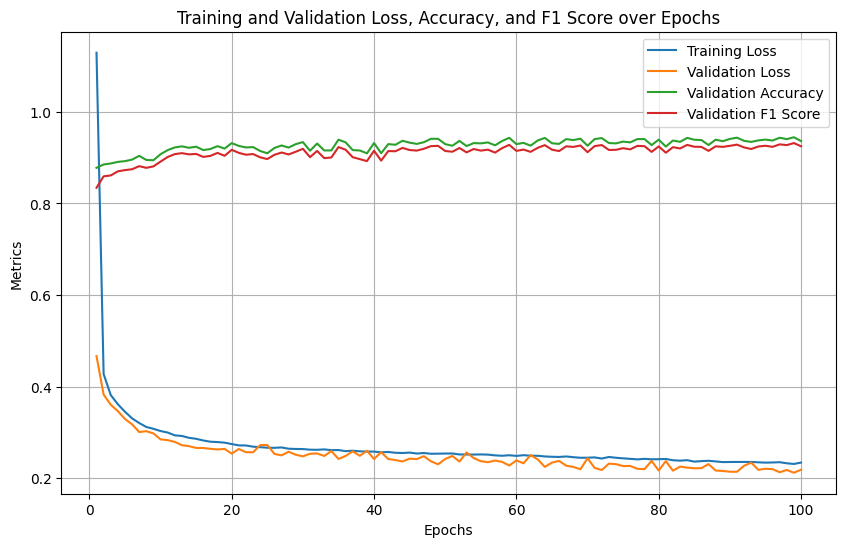

In [14]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize lists to store losses, accuracies, and F1 scores
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for x_categ, x_numer, labels in train_loader:
        # Move inputs and labels to the device (GPU or CPU)
        x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_categ, x_numer)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")


def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for x_categ, x_numer, labels in val_loader:
            x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

            # Forward pass
            outputs = model(x_categ, x_numer)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Store predictions and labels for accuracy and F1 calculation
            _, preds = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    val_f1_scores.append(f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy

# Training the model over several epochs
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')
best_val_acc = 0.0
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate after each epoch
    val_acc = validate(model, val_loader, criterion, device)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ft_transformer_model.pth")
        print("Model saved with better validation accuracy")

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Loss, Accuracy, and F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

